In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [5]:
df = pd.read_csv("PS_data.csv")

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The major observation is that isFraud is heavily imbalanced (mean is very close to 0).

In [9]:
# check for missing data 
df.isnull().sum(axis=0) 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

C:\Users\dorot\AppData\Local\Temp/ipykernel_23828/1124576285.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

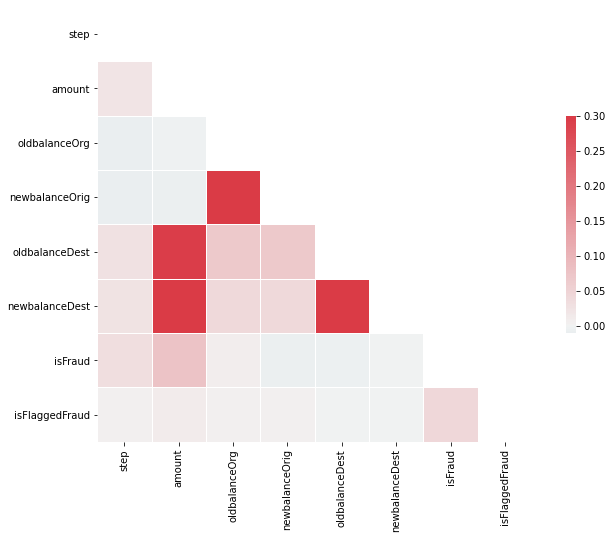

In [10]:
# explore feature correlations
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,8))

cmap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

From the heatmap, it doesn't seem like any of the features are too correlated with one another. Therefore, we will keep all of the features for now.

In [38]:
# split into dependent and independent variables
y = df['isFraud']
X = df.loc[:, ~df.columns.isin(['isFraud', 'isFlaggedFraud'])]

In [39]:
# do one-hot encoding for categorical variable
X = X.join(pd.get_dummies(X['type']))
X.drop(['type'], axis=1, inplace=True)

In [44]:
# add another column based on whether destination is merchant
X['merchant'] = [1 if x[0]=="M" else 0 for x in X['nameDest']]

In [47]:
X

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,merchant
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,0,1
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,0,1
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,0,0,0,1,0
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,0,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,1,0,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,0,0,0,1,0
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,1,0,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,0,0,0,1,0


## INSERT MORE FEATURE ENGINEERING HERE.
Particularly, it would be useful to look at the nameOrig and nameDest and perhaps engineer features based on their previous transactions. The cells below will only run once all of our columns are numerical.

In [21]:
# use an oversampling technique to correct imbalanced data
smote = SMOTE()
X_SMOTE, y_SMOTE = smote.fit_resample(X,y)
print(sorted(Counter(y_SMOTE).items()))
X_SMOTE = pd.DataFrame(X_SMOTE)
X_SMOTE.columns = X.columns
y_SMOTE = pd.DataFrame(y_SMOTE)

In [23]:
# split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE,y_SMOTE,test_size=0.30)

In [ ]:
# normalize the data
X_train_scaled = pd.DataFrame(data=preprocessing.scale(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=preprocessing.scale(X_test),columns=X_test.columns)